__Skip Connection / Bottleneck Skip connection__

![image](https://img1.daumcdn.net/thumb/R720x0.q80/?scode=mtistory2&fname=http%3A%2F%2Fcfile7.uf.tistory.com%2Fimage%2F99F0453F5C47F1741338F0)

- ResNet50 부터는 연산량의 줄이기 위해 Residual Block 내에, 1x1, 3x3, 1x1 컨볼루션 연산을 쌓았다. Inception에서 배웠던 것과 같은 개념이다. 1x1 컨볼루션 연산으로 피쳐맵의 갯수를 줄였다가 3x3을 거친 후, 1x1 컨볼루션 연산으로 차원을 늘려준다. 이 과정이 병목 같다 하여 병목레이어(bottleneck layer)라고 부른다.

__Residual Block / Identity Block__

![image](https://datascienceschool.net/upfiles/2e104ff279804e839cef46fc58ef16e7.png)

-  이미지가 반으로 작아진 경우, Identity Block이 사용되며, 입력값을 바로 더하지 않고, 1x1 컨볼루션 연산을 스트라이드 2로 설정하여 피쳐맵의 크기와 갯수를 맞추어준 다음 더해준다. 이를 프로젝션 숏컷(projection shortcut)

__ResNet Structrue by layer__

![image](https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F99167C335C47F0E315)

__Grouped Convolution__

![image](https://miro.medium.com/max/6630/1*dBrsVP0nt_PrBlICSBTttg.png)

__SENet (SE block)__

![image](https://i.imgur.com/9UFjxDA.png)

__SE block in ResNet__
![image](https://t1.daumcdn.net/cfile/tistory/9917F14A5D3EB6D535)

In [1]:
# GPU setting
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="5"

# modules setting

import numpy as np
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import datetime
from utils import one_hot, train_valid_split, random_minibatch, shuffle
from utils import training_history

# Load Data

In [2]:
train_dir =  '/mnt/disk1/yunseob/courses/19-2_computer vision/data/HHT/8ch/train'
npy_files = os.listdir(train_dir)
npy_files

['ball_7.npy',
 'ball_14.npy',
 'ball_21.npy',
 'inner_7.npy',
 'inner_14.npy',
 'inner_21.npy',
 'outer_7.npy',
 'outer_14.npy',
 'outer_21.npy',
 'normal.npy']

In [3]:
normal = np.load(os.path.join(train_dir, str([i for i in npy_files if 'normal' in i][0])))
ball_7 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'ball_7' in i][0])))
ball_14 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'ball_14' in i][0])))
ball_21 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'ball_21' in i][0])))
inner_7 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'inner_7' in i][0])))
inner_14 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'inner_14' in i][0])))
inner_21 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'inner_21' in i][0])))
outer_7 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'outer_7' in i][0])))
outer_14 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'outer_14' in i][0])))
outer_21 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'outer_21' in i][0])))

normal_y = one_hot(normal, 0, nb_classes = 10)
ball_7_y = one_hot(ball_7, 1, nb_classes = 10)
ball_14_y = one_hot(ball_14, 2, nb_classes = 10)
ball_21_y = one_hot(ball_21, 3, nb_classes = 10)
inner_7_y = one_hot(inner_7, 4, nb_classes = 10)
inner_14_y = one_hot(inner_14, 5, nb_classes = 10)
inner_21_y = one_hot(inner_21, 6, nb_classes = 10)
outer_7_y = one_hot(outer_7, 7, nb_classes = 10)
outer_14_y = one_hot(outer_14, 8, nb_classes = 10)
outer_21_y = one_hot(outer_21, 9, nb_classes = 10)

print("normal:", normal.shape, normal_y.shape)
print("ball_7:", ball_7.shape, ball_7_y.shape)
print("ball_14:", ball_14.shape, ball_14_y.shape)
print("ball_21:", ball_21.shape, ball_21_y.shape)
print("inner_7:", inner_7.shape, inner_7_y.shape)
print("inner_14:", inner_14.shape, inner_14_y.shape)
print("inner_21:", inner_21.shape, inner_21_y.shape)
print("outer_7:", outer_7.shape, outer_7_y.shape)
print("outer_14:", outer_14.shape, outer_14_y.shape)
print("outer_21:", outer_21.shape, outer_21_y.shape)

normal: (750, 100, 100, 8) (750, 10)
ball_7: (750, 100, 100, 8) (750, 10)
ball_14: (750, 100, 100, 8) (750, 10)
ball_21: (750, 100, 100, 8) (750, 10)
inner_7: (750, 100, 100, 8) (750, 10)
inner_14: (750, 100, 100, 8) (750, 10)
inner_21: (750, 100, 100, 8) (750, 10)
outer_7: (750, 100, 100, 8) (750, 10)
outer_14: (750, 100, 100, 8) (750, 10)
outer_21: (750, 100, 100, 8) (750, 10)


# Data split

In [4]:
normal_train_x, normal_train_y, normal_valid_x, normal_valid_y = train_valid_split(normal, normal_y)
print("normal:", normal_train_x.shape, normal_train_y.shape, normal_valid_x.shape, normal_valid_y.shape)

ball_7_train_x, ball_7_train_y, ball_7_valid_x, ball_7_valid_y = train_valid_split(ball_7, ball_7_y)
ball_14_train_x, ball_14_train_y, ball_14_valid_x, ball_14_valid_y = train_valid_split(ball_14, ball_14_y)
ball_21_train_x, ball_21_train_y, ball_21_valid_x, ball_21_valid_y = train_valid_split(ball_21, ball_21_y)
print("ball_7:", ball_7_train_x.shape, ball_7_train_y.shape, ball_7_valid_x.shape, ball_7_valid_y.shape)
print("ball_14:", ball_14_train_x.shape, ball_14_train_y.shape, ball_14_valid_x.shape, ball_14_valid_y.shape)
print("ball_21:", ball_21_train_x.shape, ball_21_train_y.shape, ball_21_valid_x.shape, ball_21_valid_y.shape)

inner_7_train_x, inner_7_train_y, inner_7_valid_x, inner_7_valid_y = train_valid_split(inner_7, inner_7_y)
inner_14_train_x, inner_14_train_y, inner_14_valid_x, inner_14_valid_y = train_valid_split(inner_14, inner_14_y)
inner_21_train_x, inner_21_train_y, inner_21_valid_x, inner_21_valid_y = train_valid_split(inner_21, inner_21_y)
print("inner_7:", inner_7_train_x.shape, inner_7_train_y.shape, inner_7_valid_x.shape, inner_7_valid_y.shape)
print("inner_14:", inner_14_train_x.shape, inner_14_train_y.shape, inner_14_valid_x.shape, inner_14_valid_y.shape)
print("inner_21:", inner_21_train_x.shape, inner_21_train_y.shape, inner_21_valid_x.shape, inner_21_valid_y.shape)

outer_7_train_x, outer_7_train_y, outer_7_valid_x, outer_7_valid_y = train_valid_split(outer_7, outer_7_y)
outer_14_train_x, outer_14_train_y, outer_14_valid_x, outer_14_valid_y = train_valid_split(outer_14, outer_14_y)
outer_21_train_x, outer_21_train_y, outer_21_valid_x, outer_21_valid_y = train_valid_split(outer_21, outer_21_y)
print("outer_7:", outer_7_train_x.shape, outer_7_train_y.shape, outer_7_valid_x.shape, outer_7_valid_y.shape)
print("outer_14:", outer_14_train_x.shape, outer_14_train_y.shape, outer_14_valid_x.shape, outer_14_valid_y.shape)
print("outer_21:", outer_21_train_x.shape, outer_21_train_y.shape, outer_21_valid_x.shape, outer_21_valid_y.shape)

normal: (638, 100, 100, 8) (638, 10) (112, 100, 100, 8) (112, 10)
ball_7: (638, 100, 100, 8) (638, 10) (112, 100, 100, 8) (112, 10)
ball_14: (638, 100, 100, 8) (638, 10) (112, 100, 100, 8) (112, 10)
ball_21: (638, 100, 100, 8) (638, 10) (112, 100, 100, 8) (112, 10)
inner_7: (638, 100, 100, 8) (638, 10) (112, 100, 100, 8) (112, 10)
inner_14: (638, 100, 100, 8) (638, 10) (112, 100, 100, 8) (112, 10)
inner_21: (638, 100, 100, 8) (638, 10) (112, 100, 100, 8) (112, 10)
outer_7: (638, 100, 100, 8) (638, 10) (112, 100, 100, 8) (112, 10)
outer_14: (638, 100, 100, 8) (638, 10) (112, 100, 100, 8) (112, 10)
outer_21: (638, 100, 100, 8) (638, 10) (112, 100, 100, 8) (112, 10)


In [5]:
train_X = np.vstack([normal_train_x, ball_7_train_x, ball_14_train_x, ball_21_train_x, 
                     inner_7_train_x, inner_14_train_x, inner_21_train_x,
                     outer_7_train_x, outer_14_train_x, outer_21_train_x, ])
train_Y = np.vstack([normal_train_y, ball_7_train_y, ball_14_train_y, ball_21_train_y, 
                     inner_7_train_y, inner_14_train_y, inner_21_train_y,
                     outer_7_train_y, outer_14_train_y, outer_21_train_y, ])
valid_X = np.vstack([normal_valid_x, ball_7_valid_x, ball_14_valid_x, ball_21_valid_x, 
                     inner_7_valid_x, inner_14_valid_x, inner_21_valid_x,
                     outer_7_valid_x, outer_14_valid_x, outer_21_valid_x, ])
valid_Y = np.vstack([normal_valid_y, ball_7_valid_y, ball_14_valid_y, ball_21_valid_y, 
                     inner_7_valid_y, inner_14_valid_y, inner_21_valid_y,
                     outer_7_valid_y, outer_14_valid_y, outer_21_valid_y, ])

print("Training set:", train_X.shape, train_Y.shape)
print("Validation set:", valid_X.shape, valid_Y.shape)

Training set: (6380, 100, 100, 8) (6380, 10)
Validation set: (1120, 100, 100, 8) (1120, 10)


# Model

In [6]:
input_h = 100
input_w = 100
input_ch = 8

n_g = 2

ch = 16
# 50 50 16

r_ch_1 = 32
# 25 25 32

r_ch_2 = 32
# 12 12 16

r_ch_3 = 64
# 12 12 32

r_ch_4 = 128
# 6 6 128

n_output = 10

In [10]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, input_h, input_w, input_ch], name = 'img')
y = tf.placeholder(tf.float32, [None, n_output], name = 'label')
batch_prob = tf.placeholder(tf.bool, name = 'bn_prob')

class SEResNet50_G:
    def __init__(self, n_g_1, n_g_2, n_g_3, n_g_4, ch, r_ch_1, r_ch_2, r_ch_3, r_ch_4):
        self.n_g_1 = n_g_1
        self.n_g_2 = n_g_2
        self.n_g_3 = n_g_3
        self.n_g_4 = n_g_4
        self.ch = ch
        self.r_ch_1 = r_ch_1
        self.r_ch_2 = r_ch_2
        self.r_ch_3 = r_ch_3
        self.r_ch_4 = r_ch_4
    def conv(self, x, channel, kernel_size = [3, 3], strides = (1, 1), activation = True):
        conv = tf.layers.conv2d(inputs = x, filters = channel, kernel_size = kernel_size, 
                                strides = strides, padding = "SAME")
        conv = tf.layers.batch_normalization(conv, center=True, scale=True, training=batch_prob)
        if activation == True:
            conv = tf.nn.relu(conv)
        return conv
    
    def grouped_conv(self, x, n_g, channel, kernel_size = [3, 3], strides = (1, 1), activation = True):
        input_groups = tf.split(value = x, num_or_size_splits= n_g, axis = -1)

        output_groups = [
            tf.layers.conv2d(input_groups[i], filters = channel/n_g, kernel_size = kernel_size, strides = strides, padding = "SAME")
            for i in range(n_g)
        ]
        output = tf.concat(output_groups, axis = -1)
        output = tf.layers.batch_normalization(output, center=True, scale=True, training=batch_prob)
        if activation != False:
            output = tf.nn.relu(output)
        return output
    
    def maxp(self, conv):
        maxp = tf.layers.max_pooling2d(inputs = conv, pool_size = [2, 2], strides = 2)
        return maxp

    def SE_block(self, x, channel = None, reduction_ratio = 4):
        ch_reduced = channel/reduction_ratio #8
        x_in = x #25 25 32
        squeeze = self.global_avg_pooling(x_in) # 32
        #8
        excitation =  tf.layers.dense(inputs = squeeze, units = ch_reduced, 
                                      kernel_initializer = tf.contrib.layers.variance_scaling_initializer(uniform=False, factor=2.0, mode='FAN_IN', dtype=tf.float32),
                                      activation = tf.nn.relu, use_bias = False)
        #32
        excitation =  tf.layers.dense(inputs = excitation, units = channel, 
                                      kernel_initializer = tf.contrib.layers.variance_scaling_initializer(uniform=False, factor=2.0, mode='FAN_IN', dtype=tf.float32),
                                      activation = tf.nn.sigmoid, use_bias = False)
#         excitation =  tf.layers.dense(inputs = squeeze, units = ch_reduced, activation = tf.nn.relu, use_bias = False)
#         excitation =  tf.layers.dense(inputs = excitation, units = channel, activation = tf.nn.sigmoid, use_bias = False)
        excitation = tf.reshape(excitation, [-1, 1, 1, channel]) # 1 1 32
        scale = tf.multiply(x_in, excitation) #25 25 32 x 1 1 32    25 25 64 ???
        
        return scale

    def SE_res_block(self, x, n_g, channel, strides = (1, 1), reduction_ratio = 4):
        #25 25 16
        conv_a = self.grouped_conv(x, n_g, channel/4, kernel_size = [1, 1], strides = strides) #25 25 8 
        conv_b = self.grouped_conv(conv_a, n_g, channel/4, kernel_size = [3, 3]) #25 25 8
        conv_c = self.grouped_conv(conv_b, n_g, channel, kernel_size = [1, 1], activation = False) #25 25 32   25 25 64 ?
        se = self.SE_block(conv_c, channel, reduction_ratio = 4) # 1 1 32

        proj_input = self.grouped_conv(x, n_g, channel, kernel_size = [1, 1], strides = strides, activation = False) # 25 25 64 ?
        
        return tf.nn.relu(proj_input + se)

    def SE_res_stage(self, x, n_g, target_ch, reduction_ratio = 4, downsample = False, n_rep = None):
        strides = (2, 2) if downsample != False else (1, 1)
       
        x = self.SE_res_block(x, n_g, target_ch, strides)
        for _ in range(n_rep-1):
            x = self.SE_res_block(x, n_g, target_ch)
        return x

    def fc_layer(self, gap, n_output = None):
        flatten = tf.layers.flatten(gap)
        output = tf.layers.dense(inputs = flatten, units = n_output)
        return output

    def global_avg_pooling(self, x):
        gap = tf.reduce_mean(x, axis=[1, 2], keepdims=True)
        return gap

    def inf(self, x):
        """
        conv_1: 1
        id_~ + resnet_~: 16 x 3 = 48
        fc_lay: 1

        total: 50
        """
        conv_1 = self.grouped_conv(x, self.n_g_1, self.ch, strides = (2, 2))
        maxp_1 = self.maxp(conv_1)
        se_1 = self.SE_res_stage(maxp_1, self.n_g_1, target_ch = self.r_ch_1, downsample = False, n_rep = 3)
        se_2 = self.SE_res_stage(se_1, self.n_g_2, target_ch = self.r_ch_2, downsample = True, n_rep = 4)
        se_3 = self.SE_res_stage(se_2, self.n_g_3, target_ch = self.r_ch_3, downsample = True, n_rep = 6)
        se_4 = self.SE_res_stage(se_3, self.n_g_4, target_ch = self.r_ch_4, downsample = True, n_rep = 3)
        gap = self.global_avg_pooling(se_4)
        score = self.fc_layer(gap, n_output)
        return score

    
model = SEResNet50_G(8, 4, 2, 1, ch, r_ch_1, r_ch_2, r_ch_3, r_ch_4)
score = model.inf(x)
loss = tf.losses.softmax_cross_entropy(onehot_labels=y, logits=score)
loss = tf.reduce_mean(loss)

W1215 22:23:51.996514 140540890539776 deprecation.py:323] From <ipython-input-10-3de4c5479398>:31: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W1215 22:23:52.006990 140540890539776 deprecation.py:506] From /home/yunseob/.local/lib/python3.5/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1215 22:23:52.284684 140540890539776 deprecation.py:323] From <ipython-input-10-3de4c5479398>:34: batch_normalization (from tensorflow.python.layers.normalization) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_d

# Training

In [11]:
t_batch = 8
v_batch = 64
n_cal = 10
n_prt = 100

n_iter = 0

# LR = 1e-4 # 1e-4 ~ 5e-4 (xavier)
lr = 1e-4

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optm = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)
# optm = tf.train.AdamOptimizer(lr).minimize(loss)

saver = tf.train.Saver()
sess = tf.Session()

init = tf.global_variables_initializer()
sess.run(init)
start_time = time.time() 

accr_train, accr_valid, loss_train, loss_valid = [], [], [], []
early_stopping = False

hist = training_history(accr_train, accr_valid, loss_train, loss_valid)
hist.table()

while True:
    train_x, train_y = random_minibatch(train_X, train_Y, batch_size = t_batch)
#     train_n_x, train_n_y = random_minibatch(train_noise_X, train_noise_Y, batch_size = t_batch)
#     train_x, train_y = np.concatenate((train_x, train_n_x), axis = 0), np.concatenate((train_y, train_n_y), axis = 0)
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'bn_prob:0' :1})
    n_iter += 1
    if n_iter % n_cal == 0:
        c, p = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'bn_prob:0' :0})

        p = np.argmax(p, axis = 1)
        l = np.argmax(train_y, axis = 1)
        a = np.mean(np.equal(p, l))
        
        valid_x, valid_y = random_minibatch(valid_X, valid_Y, batch_size = v_batch)
#         valid_n_x, valid_n_y = random_minibatch(valid_noise_X, valid_noise_Y, batch_size = v_batch)
#         valid_x, valid_y = np.concatenate((valid_x, valid_n_x), axis = 0), np.concatenate((valid_y, valid_n_y), axis = 0)
        
        c_valid, p_valid = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'bn_prob:0' :0})

        p_valid = np.argmax(p_valid, axis = 1)
        l_valid = np.argmax(valid_y, axis = 1)
        a_valid = np.mean(np.equal(p_valid, l_valid))

        accr_valid.append(a_valid)
        loss_valid.append(c_valid)
        accr_train.append(a)
        loss_train.append(c)

        if n_iter % n_prt == 0:
            hist.prt_evl(n_iter)

        if loss_valid[-1] == np.min(loss_valid):
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%y%m%d%H%M')
            model_name = 'hht_8ch_seres50g_v2_{0}_{1}_val_acc_{2:.2f}_val_loss_{3:.6f}'.format(nowDatetime, n_iter, accr_valid[-1], loss_valid[-1])
            saver.save(sess, './model/HHT/' + model_name)
        if n_iter == 40000:
            break
#         if n_iter > 1000:
#             if np.max(accr_train) < 0.9:
#                 if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
#                     hist.early_under(n_iter)
#                     early_stopping = True
#                     break
#             if np.mean(accr_train[-50:]) >= 0.995:
#                 if (
#                     np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
#                     loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
#                     ):
#                     hist.early_over(n_iter)
#                     early_stopping = True
#                     break          

train_time = int((time.time() - start_time)/60)  
hist.done(n_iter, train_time, early_stopping)

np.save('/mnt/disk1/yunseob/courses/19-2_computer vision/history/SEResNet50G_v2_HHT_8ch_accr', np.array(accr_train))
np.save('/mnt/disk1/yunseob/courses/19-2_computer vision/history/SEResNet50G_v2_HHT_8ch_loss', np.array(loss_train))

hist.plot(n_cal)   

# sess.close()

[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss
[*100] || 37.50 %    || 1.56 %    || 2.19462276 || 2.27822447
--------------------------------------------------------------
[*200] || 12.50 %    || 4.69 %    || 2.44580221 || 2.69078445
--------------------------------------------------------------
[*300] || 0.00 %    || 10.94 %    || 2.87599730 || 2.82447863
--------------------------------------------------------------
[*400] || 37.50 %    || 6.25 %    || 1.93224406 || 2.88765144
--------------------------------------------------------------


W1215 22:26:10.704077 140540890539776 deprecation.py:323] From /home/yunseob/.local/lib/python3.5/site-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


[*500] || 50.00 %    || 26.56 %    || 1.61898375 || 1.84564972
--------------------------------------------------------------
[*600] || 50.00 %    || 31.25 %    || 1.16177416 || 1.57154405
--------------------------------------------------------------
[*700] || 62.50 %    || 53.12 %    || 1.13276529 || 1.05497658
--------------------------------------------------------------
[*800] || 37.50 %    || 56.25 %    || 1.18466842 || 1.16199732
--------------------------------------------------------------
[*900] || 87.50 %    || 50.00 %    || 0.98392761 || 1.13315320
--------------------------------------------------------------
[1000] || 62.50 %    || 54.69 %    || 1.18472815 || 1.13216329
--------------------------------------------------------------
[1100] || 62.50 %    || 65.62 %    || 0.96869087 || 0.99033284
--------------------------------------------------------------
[1200] || 100.00 %    || 67.19 %    || 0.44079399 || 0.83053452
------------------------------------------------------

[7000] || 87.50 %    || 89.06 %    || 0.53957766 || 0.35451967
--------------------------------------------------------------
[7100] || 87.50 %    || 79.69 %    || 0.30147025 || 0.51957941
--------------------------------------------------------------
[7200] || 25.00 %    || 70.31 %    || 2.08458304 || 0.88407409
--------------------------------------------------------------
[7300] || 50.00 %    || 78.12 %    || 2.24638128 || 0.66483724
--------------------------------------------------------------
[7400] || 87.50 %    || 82.81 %    || 0.95799339 || 0.62327361
--------------------------------------------------------------
[7500] || 62.50 %    || 89.06 %    || 1.16902661 || 0.31504551
--------------------------------------------------------------
[7600] || 75.00 %    || 67.19 %    || 0.86455721 || 1.11651492
--------------------------------------------------------------
[7700] || 87.50 %    || 82.81 %    || 0.32721466 || 0.48649862
-------------------------------------------------------

[13500] || 100.00 %    || 95.31 %    || 0.02836225 || 0.10599025
--------------------------------------------------------------
[13600] || 100.00 %    || 96.88 %    || 0.02067047 || 0.05652748
--------------------------------------------------------------
[13700] || 100.00 %    || 95.31 %    || 0.09175879 || 0.13503839
--------------------------------------------------------------
[13800] || 100.00 %    || 90.62 %    || 0.01158567 || 0.30022302
--------------------------------------------------------------
[13900] || 100.00 %    || 96.88 %    || 0.00819770 || 0.05351329
--------------------------------------------------------------
[14000] || 75.00 %    || 71.88 %    || 0.61709130 || 1.43068063
--------------------------------------------------------------
[14100] || 100.00 %    || 89.06 %    || 0.00691264 || 0.38425356
--------------------------------------------------------------
[14200] || 75.00 %    || 81.25 %    || 0.59366745 || 0.66945320
-----------------------------------------

[20000] || 100.00 %    || 90.62 %    || 0.01202394 || 0.29653043
--------------------------------------------------------------
[20100] || 100.00 %    || 98.44 %    || 0.01700885 || 0.09038829
--------------------------------------------------------------
[20200] || 100.00 %    || 100.00 %    || 0.06134918 || 0.01054776
--------------------------------------------------------------
[20300] || 75.00 %    || 98.44 %    || 0.69319242 || 0.02706819
--------------------------------------------------------------
[20400] || 100.00 %    || 100.00 %    || 0.00634874 || 0.01026803
--------------------------------------------------------------
[20500] || 100.00 %    || 85.94 %    || 0.13291201 || 0.37661973
--------------------------------------------------------------


KeyboardInterrupt: 

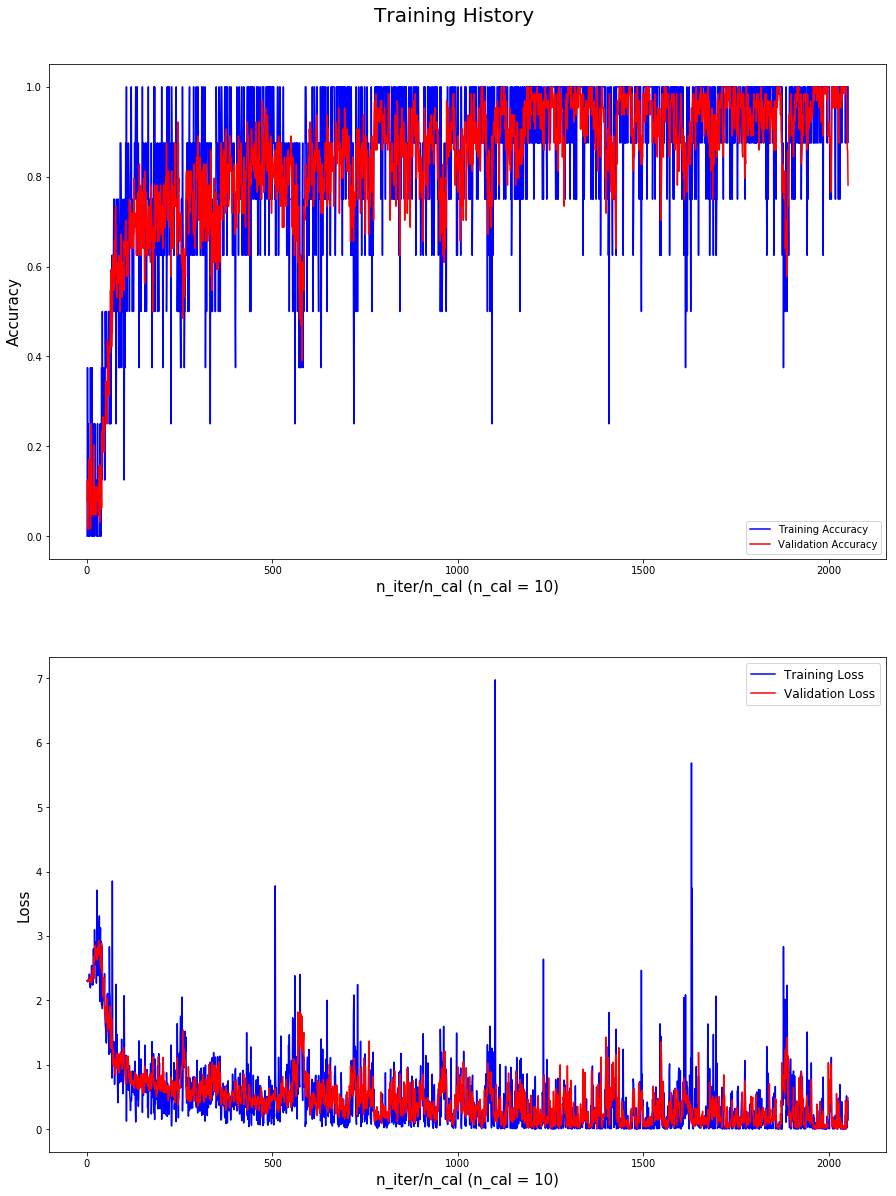

In [12]:
hist.plot(n_cal)